На проекте, где пользователь может отправить лайк другому пользователю, для увеличения количества лайков провели тест на замену сердца на галочку. При нажатии на крестик пользователю предлагается следующий пользователь. Тестовый вариант внедрили на пользователях с нечетным sender_id 24 марта в 16:00, на четных пользователях оставили базовый вариант.							


Вопрос
Нужно ли внедрить нововведение для всех или отклонить его?
Подкрепите выводы графиками


sender_id -уникальный идентификатор отправителя

platform_id - id платформы, 6 - декстоп, 7 - мобильная версия

time_stamp -Дата и время отправки

gender - Гендер отправителя

reg_date Дата регистрации пользователя

In [2]:
import pandas as pd

from pathlib import Path
import sys

PATH = '/Users/danil/Documents/github/appflame'
sys.path.append(str(PATH))

In [28]:
import matplotlib.pyplot as plt

In [191]:
df = pd.read_csv(PATH + '/data/raw/Test_4.csv', sep = ';')

print(df.shape)
df.head()

(768439, 5)


,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


In [5]:
df['platform_id'].value_counts()/df.shape[0]

6    0.580517
7    0.419483
Name: platform_id, dtype: float64

In [10]:
df['gender'].value_counts()/df.shape[0]

m    0.858323
f    0.141454
     0.000223
Name: gender, dtype: float64

In [8]:
print('min:', df['reg_date'].min(), 'max:', df['reg_date'].max())

min: 01.01.2017 max: 31.01.2017


In [9]:
print('min:', df['time_stamp'].min(), 'max:', df['time_stamp'].max())

min: 13.03.2017 0:00 max: 27.03.2017 0:00


смотрим как отправляли в зависимости от дня и времени суток

сравнивать какой показатель? среднее количество лайков за день? за час? скорее просто количество лайков за все время поделенное на количество часов (или на количество часов в сети) 
наверно среднее количество лайков в час, чтобы потом получить значения лайков и построить доверительные интервалы. 

сравнить количество лайков на первом этапе жизни старых пользователей и тех которые зарегались уже для нового банера

In [225]:
df_16h = df.copy()

In [226]:
df_16h['time_stamp'] = pd.to_datetime(df_16h['time_stamp'])
df_16h['time_stamp'] = df_16h['time_stamp'] - pd.Timedelta(hours=16)

df_16h['date'] = df_16h['time_stamp'].dt.date
df_16h['DOW'] = df_16h['time_stamp'].dt.weekday

In [227]:
likes_per_day = df_16h['date'].value_counts().sort_index()[:-1]

for better visualization I will substract 16 housr from time_stamp and now test starts from 24 of March

In [228]:
likes_per_day_weekdays = pd.Series(pd.to_datetime(likes_per_day.index)).dt.day_name()
likes_per_day_weekdays

0        Sunday
1        Monday
2       Tuesday
3     Wednesday
4      Thursday
5        Friday
6      Saturday
7        Sunday
8        Monday
9       Tuesday
10    Wednesday
11     Thursday
12       Friday
13     Saturday
dtype: object

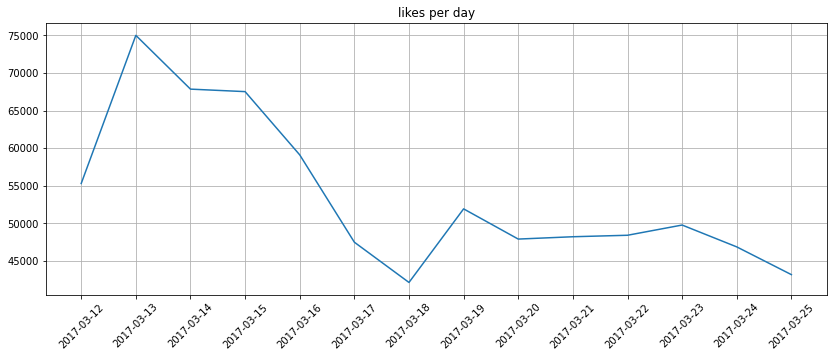

In [229]:
likes_per_day.plot(figsize=(14,5), grid = True, xticks=likes_per_day.index).set_title('likes per day');
plt.xticks(rotation=45);

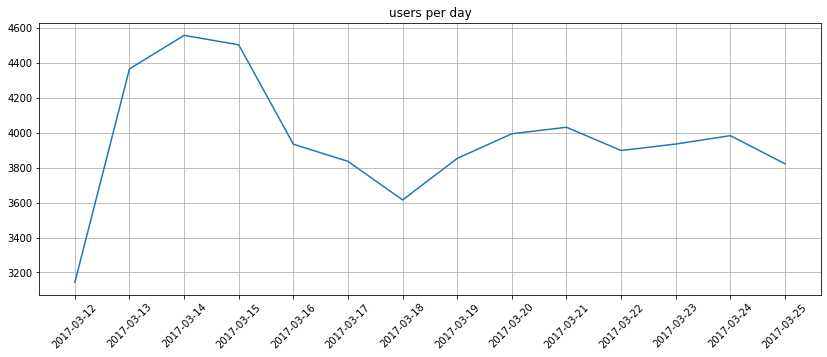

In [230]:
users_per_day = df_16h[['sender_id', 'date']].drop_duplicates()['date'].value_counts()[:-1]
users_per_day.plot(figsize=(14,5), grid = True, xticks=users_per_day.index).set_title('users per day');
plt.xticks(rotation=45);

In [231]:
user_likes_per_day = likes_per_day / users_per_day

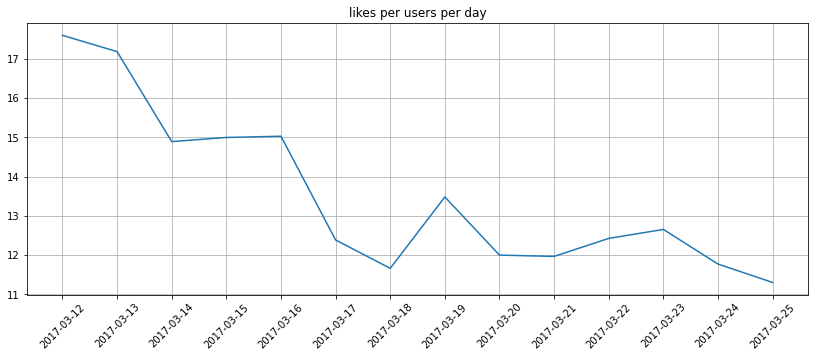

In [233]:
user_likes_per_day.plot(figsize=(14,5), grid = True, xticks=user_likes_per_day.index).set_title('likes per users per day');
plt.xticks(rotation=45);

In [234]:
def is_odd(x):
    if x % 2 == 0:
        res = 0
    else:
        res = 1
    return res

In [235]:
df_16h['test_group'] = df_16h['sender_id'].apply(is_odd)

In [236]:
df_16h.head()

,sender_id,platform_id,time_stamp,gender,reg_date,date,DOW,test_group,time_stamp_-16h
0,3207526951,6,2017-03-15 21:35:00,m,26.01.2017,2017-03-15,2,1,2017-03-15 21:35:00
1,3207526951,6,2017-03-15 17:09:00,m,26.01.2017,2017-03-15,2,1,2017-03-15 17:09:00
2,3207526951,6,2017-03-15 17:09:00,m,26.01.2017,2017-03-15,2,1,2017-03-15 17:09:00
3,3207526951,6,2017-03-15 20:13:00,m,26.01.2017,2017-03-15,2,1,2017-03-15 20:13:00
4,3207526951,6,2017-03-14 22:01:00,m,26.01.2017,2017-03-14,1,1,2017-03-14 22:01:00


In [198]:
# df = df[df['time_stamp'] < '2017-03-27']

In [237]:
df_16h_p = df_16h.groupby(['date', 'test_group']).test_group.count().reset_index(name="count")

In [238]:
df_plot = df_16h_p.pivot(index='date', columns='test_group', values='count')

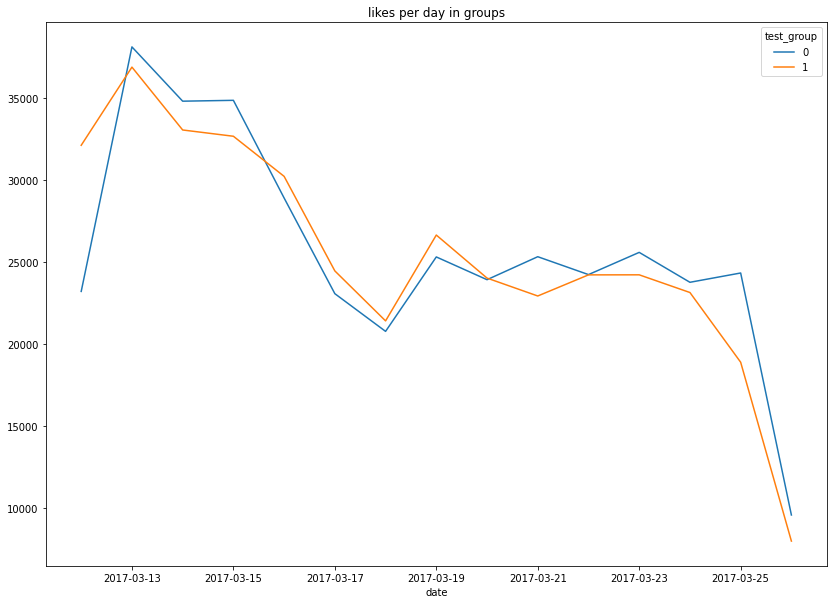

In [239]:
df_plot.plot(figsize = (14, 10)).set_title('likes per day in groups');

as we can see that even before test, behaviour groups was not very similar

In [240]:
from collections import Counter

In [241]:
group_balance = Counter(map(is_odd, df_16h['sender_id'].unique()))

as we can see that odd user group has less users

In [242]:
df_16h_p.head()

,date,test_group,count
0,2017-03-12,0,23198
1,2017-03-12,1,32118
2,2017-03-13,0,38124
3,2017-03-13,1,36890
4,2017-03-14,0,34811


In [243]:
df_likes_per_day_per_group = df_16h.groupby(['date', 'test_group']).test_group.count().reset_index(name="count")

In [244]:
df_likes_per_day_per_group.tail()

,date,test_group,count
25,2017-03-24,1,23131
26,2017-03-25,0,24323
27,2017-03-25,1,18875
28,2017-03-26,0,9550
29,2017-03-26,1,7957


In [245]:
df_users_per_day_per_group = df_16h.groupby(['date', 'test_group']).sender_id.nunique().reset_index(name="count")

In [246]:
df_users_per_day_per_group.tail()

,date,test_group,count
25,2017-03-24,1,1969
26,2017-03-25,0,1958
27,2017-03-25,1,1864
28,2017-03-26,0,920
29,2017-03-26,1,866


In [247]:
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

In [248]:
df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')

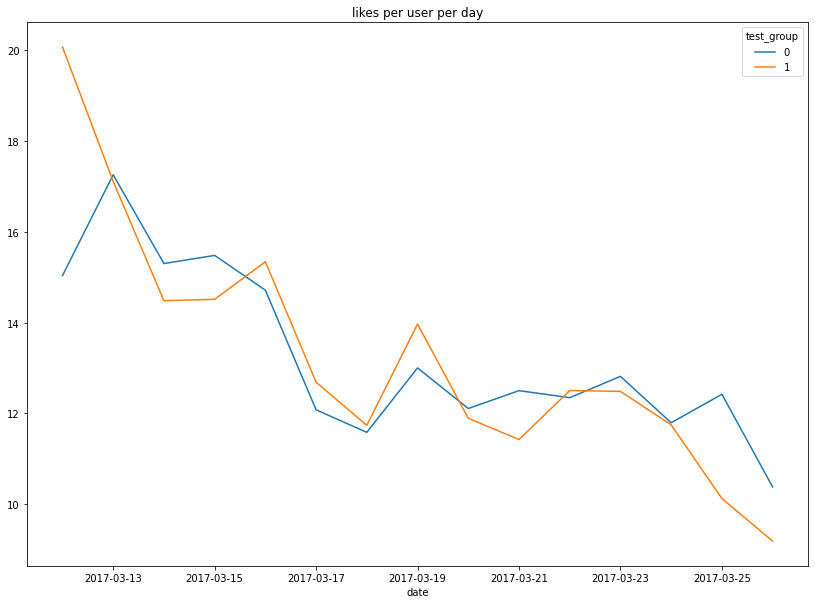

In [249]:
df_plot.plot(figsize = (14, 10)).set_title('likes per user per day');

as we can see even likes per user in group declining, => new banner has lower CTR

lets check difference between groups

In [254]:
difference = (df_plot[0] - df_plot[1])

In [255]:
difference

date
2017-03-12   -5.039401
2017-03-13    0.148098
2017-03-14    0.817314
2017-03-15    0.967356
2017-03-16   -0.625740
2017-03-17   -0.608493
2017-03-18   -0.154080
2017-03-19   -0.966492
2017-03-20    0.215338
2017-03-21    1.076998
2017-03-22   -0.157037
2017-03-23    0.329799
2017-03-24    0.047348
2017-03-25    2.296297
2017-03-26    1.192213
dtype: float64

In [259]:
mean = difference.values[:-3].mean()
std = difference.values[:-3].std()

In [260]:
[mean - 2 * std, mean + 2 * std]

[-3.4287119142570166, 2.7626552131611612]

and all values after 2017-03-24 lay in that boundaries => this is not confident information to say that new banner worth than original

In [76]:
ab_df = df[df['time_stamp'] >= '2017-03-24 16:00:00']

In [78]:
ab_df.sort_values('time_stamp')

,sender_id,platform_id,time_stamp,gender,reg_date,date,DOW
295310,3217917298,7,2017-03-24 16:00:00,f,19.03.2017,2017-03-24,4
558717,3205198691,7,2017-03-24 16:00:00,m,15.01.2017,2017-03-24,4
558724,3205198691,7,2017-03-24 16:00:00,m,15.01.2017,2017-03-24,4
558725,3205198691,7,2017-03-24 16:00:00,m,15.01.2017,2017-03-24,4
198599,3205140908,6,2017-03-24 16:00:00,m,15.01.2017,2017-03-24,4
...,...,...,...,...,...,...,...
277231,3219303136,6,2017-03-26 23:59:00,f,26.03.2017,2017-03-26,6
277325,3219308377,7,2017-03-26 23:59:00,m,26.03.2017,2017-03-26,6
277313,3219308377,7,2017-03-26 23:59:00,m,26.03.2017,2017-03-26,6
665169,3212514032,6,2017-03-26 23:59:00,m,19.02.2017,2017-03-26,6


In [86]:
ab_df.head()

,sender_id,platform_id,time_stamp,gender,reg_date,date,DOW,test_group
150161,3218632174,7,2017-03-26 07:34:00,m,23.03.2017,2017-03-26,6,0
150162,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,6,1
150163,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,6,1
150164,3218635027,7,2017-03-26 06:18:00,m,23.03.2017,2017-03-26,6,1
150165,3218635027,7,2017-03-26 06:19:00,m,23.03.2017,2017-03-26,6,1


In [87]:
ab_df['test_group'].value_counts()

0    57628
1    49964
Name: test_group, dtype: int64

just for now, there were more likes on old banner

In [89]:
ab_df['gender'].value_counts()

m    93525
f    14044
        23
Name: gender, dtype: int64

In [94]:
ab_df[ab_df['gender'] != ' '].groupby(['gender', 'test_group']).test_group.count()

gender  test_group
f       0              7078
        1              6966
m       0             50550
        1             42975
Name: test_group, dtype: int64

male started to make less likes

In [95]:
ab_df.groupby(['platform_id', 'test_group']).test_group.count()

platform_id  test_group
6            0             30107
             1             27401
7            0             27521
             1             22563
Name: test_group, dtype: int64

from mobile version we see bigger decline, than from desctop

In [106]:
ab_df.loc[: ,'reg_date'] = pd.to_datetime(ab_df['reg_date'])

In [112]:
ab_df.loc[:, 'new_user'] = ab_df.eval('reg_date >= time_stamp').astype('uint8')

In [116]:
ab_df.groupby(['new_user', 'test_group']).test_group.count()

new_user  test_group
0         0             42459
          1             38135
1         0             15169
          1             11829
Name: test_group, dtype: int64

in both cases, for new users abd for old ones old design more clicable